In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from fredapi import Fred
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings("ignore")

In [364]:
# Collect data of Korea and Euro exchange rate with USD
fred = Fred(api_key="cf557e0d1ba2550990a5fb744f4f2ba9")
ids = {}
countries = ["korea","euro"]
for country in countries:
    ids[country] = fred.search(f"{country}") # df
    temp_df = ids[country]
    id = temp_df[temp_df["title"].str.contains("Exchange Rate")]["id"][0]
    ids[country] = id
ids

{'korea': 'DEXKOUS', 'euro': 'DEXUSEU'}

In [365]:
# Call the API
korea_exchange = fred.get_series(series_id=ids["korea"])
euro_exchange = fred.get_series(series_id=ids["euro"])

In [366]:
# Preprocess the raw data, convert dtype, filter to the time range from 2014-2024
def preprocess(series,name=""):
    df = pd.DataFrame({"rate":series})
    df["date"] = df.index.year.astype(str) + '-' + df.index.month.astype(str).str.zfill(2)
    monthly_df = df.groupby("date").mean()
    monthly_df = monthly_df.loc["2014-08":"2024-08"]
    monthly_df.index = pd.to_datetime(monthly_df.index)
    plt.plot(monthly_df["rate"])
    plt.grid(True)
    plt.title(f"Exchange rate of {name}-USD")
    return monthly_df 

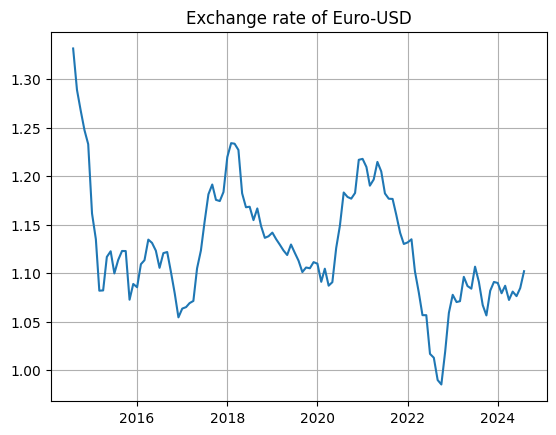

In [367]:
euro_df = preprocess(euro_exchange,"Euro")

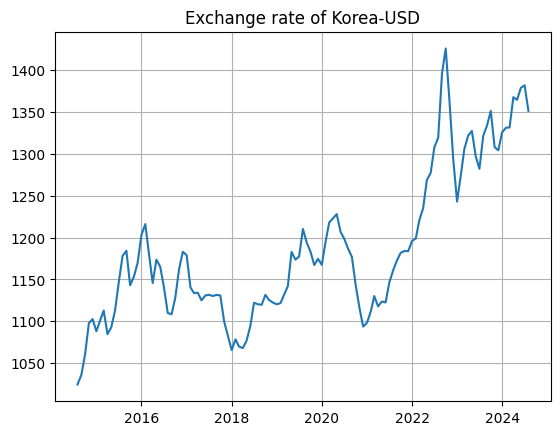

In [368]:
korea_df = preprocess(korea_exchange,"Korea")

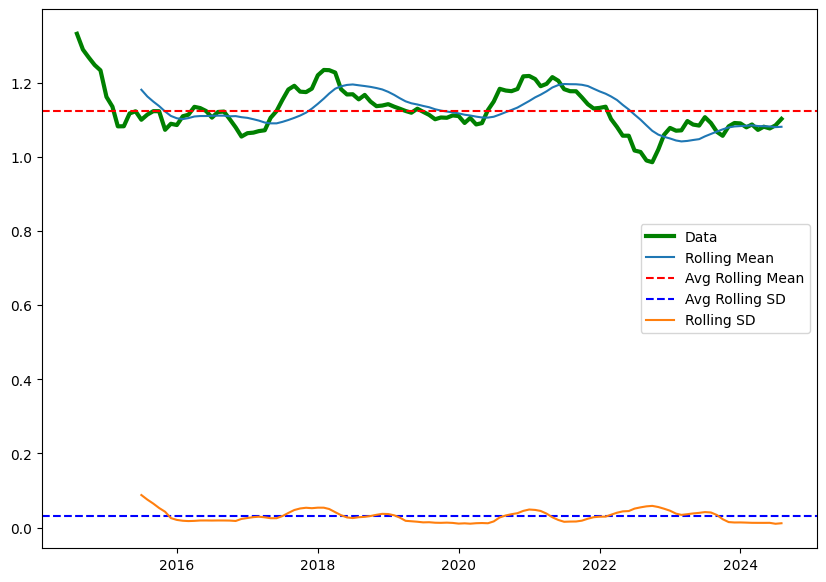

In [369]:
# Visualize the series' rolling means to detect non-stationarity
window_size=12
plt.figure(figsize=(10,7))
rolling_mean = euro_df["rate"].rolling(window=window_size).mean()
rolling_std = euro_df["rate"].rolling(window=window_size).std()
plt.plot(euro_df["rate"],color="g",label="Data",linewidth=3)
plt.plot(rolling_mean, label="Rolling Mean")
plt.axhline(y=np.mean(rolling_mean),color="r",linestyle='--',label="Avg Rolling Mean")
plt.axhline(y=np.mean(rolling_std),color="b",linestyle="--",label="Avg Rolling SD")
plt.plot(rolling_std, label="Rolling SD")
plt.title("Rolling Stats of Euro")
plt.legend();

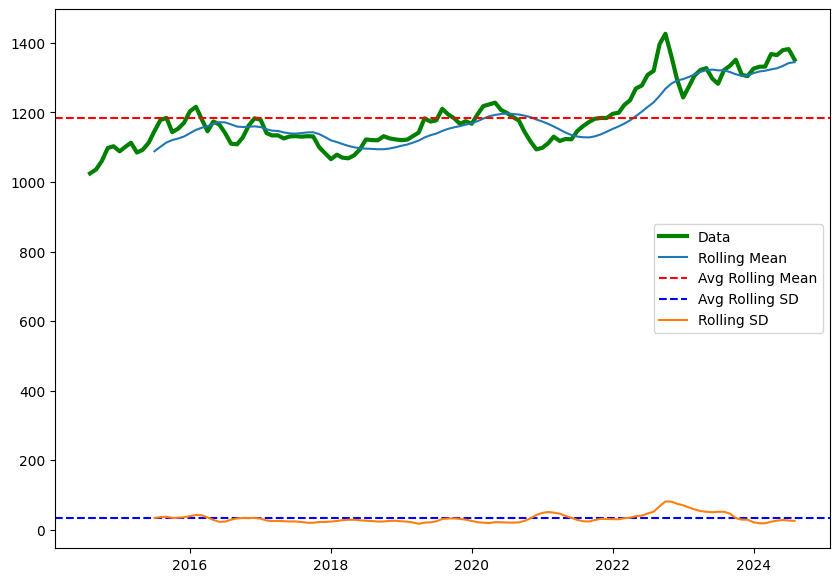

In [370]:
# Visualize the series' rolling means to detect non-stationarity
window_size=12
plt.figure(figsize=(10,7))
rolling_mean = korea_df["rate"].rolling(window=window_size).mean()
rolling_std = korea_df["rate"].rolling(window=window_size).std()
plt.plot(korea_df["rate"],color="g",label="Data",linewidth=3)
plt.plot(rolling_mean, label="Rolling Mean")
plt.axhline(y=np.mean(rolling_mean),color="r",linestyle='--',label="Avg Rolling Mean")
plt.axhline(y=np.mean(rolling_std),color="b",linestyle="--",label="Avg Rolling SD")
plt.plot(rolling_std, label="Rolling SD")
plt.title("Rolling Stats of Korea")
plt.legend();

In [371]:
def adf_test(series,name=""):
    adf = adfuller(series)
    print("Estimate:",adf[0])
    print("P value:", adf[1])
    if adf[1] < 0.05:
        print(f"{name} series is stationary with statistical significance")
    else:
        print(f"Fail to reject non-stationarity in {name} series")
    print("")

In [372]:
# Adjusted Dickey Fuller test: H0 = non-stationarity
adf_test(euro_df["rate"],"Euro")
adf_test(korea_df["rate"],"Korea")
# Euro series just exceeds 5% a little => weak evidence of stationarity => still log difference 

Estimate: -3.6179472943131534
P value: 0.005427039699422183
Euro series is stationary with statistical significance

Estimate: -0.8343333474502022
P value: 0.8088283326799182
Fail to reject non-stationarity in Korea series



In [373]:
korea_df["diff"] = korea_df["rate"] - korea_df["rate"].shift(1)
euro_df["logdiff"] = np.log(euro_df["rate"]) - np.log(euro_df["rate"].shift(1))
korea_df.fillna(0,inplace=True)
euro_df["diff"] = euro_df["rate"] - euro_df["rate"].shift(1)
euro_df["logdiff"] = np.log(euro_df["rate"]) - np.log(euro_df["rate"].shift(1))
euro_df.fillna(0,inplace=True)

Estimate: -7.933447952436577
P value: 3.4635791721359897e-12
 series is stationary with statistical significance



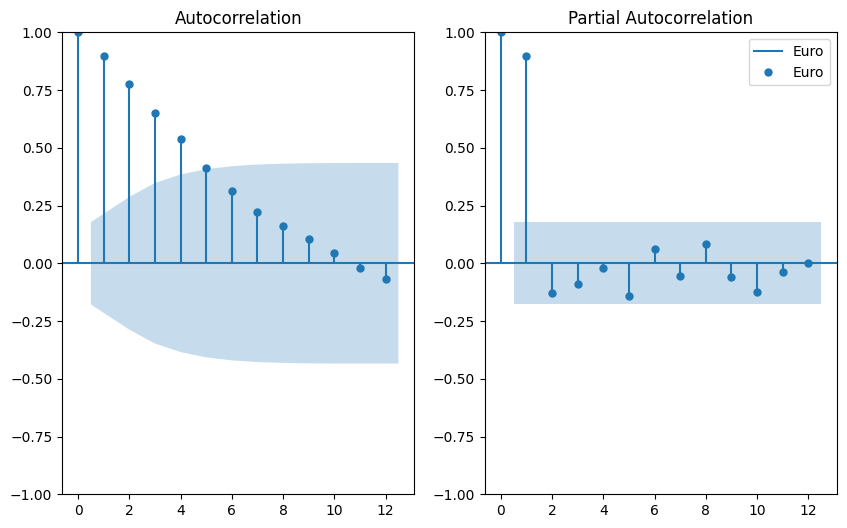

In [374]:
# Autocorrelations and Partial-autocorrelations plots 
fig, axs = plt.subplots(1,2, figsize=(10,6))
plot_acf(euro_df["diff"],ax=axs[0], lags=12,label="Euro")
plot_pacf(euro_df["diff"],ax=axs[1],lags=12,label="Euro")
plt.legend();

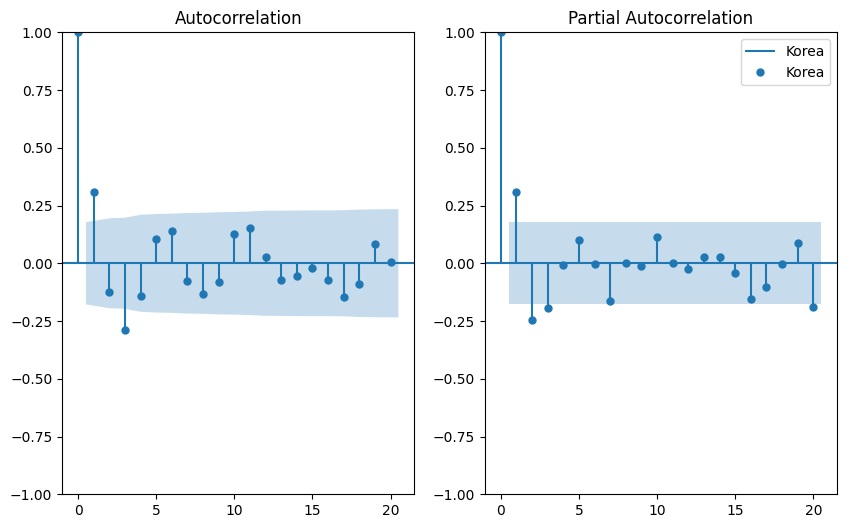

In [375]:
# Autocorrelations and Partial-autocorrelations plots 
fig, axs = plt.subplots(1,2, figsize=(10,6))
plot_acf(korea_df["diff"],ax=axs[0], lags=20,label="Korea")
plot_pacf(korea_df["diff"],ax=axs[1],lags=20,label="Korea")
plt.legend();

In [376]:
# Test for serial correlation: H0: no correlation
acorr_ljungbox(euro_df["diff"])

,lb_stat,lb_pvalue
1,99.386416,2.077426e-23
2,174.615929,1.209575e-38
3,228.025516,3.695832e-49
4,264.626294,4.592015e-56
5,286.242489,9.071871e-60
6,298.848853,1.443517e-61
7,305.217601,4.648777e-62
8,308.718593,5.734876e-62
9,310.240351,1.752688e-61
10,310.495230,9.374918e-61


In [377]:
acorr_ljungbox(korea_df["diff"])

,lb_stat,lb_pvalue
1,11.920318,0.000555
2,13.876148,0.000970
3,24.373941,0.000021
4,26.999459,0.000020
5,28.372380,0.000031
6,30.972817,0.000026
7,31.748628,0.000045
8,34.061584,0.000040
9,34.972609,0.000060
10,37.103338,0.000054


In [453]:
# Let's make it more robust by using the Box-Jenkins procedure which minimizes AIC/BIC criteria. 
# We'll simplify the analysis by coercing seasonal differencing to be 0 for now and explore more complex specifications later.
euro_params = auto_arima(euro_df["logdiff"],start_o=1,max_p=5,start_q=1,max_q=5,m=12,d=None,D=1,trace=True,error_action="ignore",stepwise=True,seasonal=True)
print(euro_params.order)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=-541.929, Time=2.48 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-497.815, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-534.146, Time=0.54 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-545.282, Time=0.73 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-499.182, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-506.760, Time=0.24 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-543.669, Time=3.52 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-531.634, Time=0.71 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=-541.677, Time=2.65 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-539.038, Time=0.79 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-545.805, Time=1.72 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-508.327, Time=0.08 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-544.003, Time=1.96 sec
 ARIMA(1,0,1)(0,1,2)[12]

In [463]:
korea_params = auto_arima(korea_df["logdiff"],start_o=1,max_p=5,start_q=1,max_q=5,m=12,d=None,D=1,trace=True,error_action="ignore",stepwise=True,seasonal=True)
print(korea_params.order)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=-539.512, Time=2.36 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-480.549, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-527.276, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-540.069, Time=1.01 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-482.441, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-492.825, Time=0.28 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-539.938, Time=1.60 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-540.268, Time=2.66 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=4.73 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=-529.730, Time=1.15 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-538.344, Time=2.25 sec
 ARIMA(0,0,2)(0,1,2)[12] intercept   : AIC=-538.546, Time=2.79 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-538.216, Time=1.84 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-536.572, Time=4.00 sec
 ARIMA(0,0,1)(0,1,2)[12]

In [462]:
# Model fitting
size = 0.9
euro_train = euro_df["logdiff"][:int(size*euro_df.shape[0])]
euro_test = euro_df["logdiff"][int(size*euro_df.shape[0]):]
korea_train = korea_df["logdiff"][:int(size*korea_df.shape[0])]
korea_test = korea_df["logdiff"][int(size*korea_df.shape[0]):]

In [382]:
euro_train.shape,euro_test.shape,korea_train.shape,korea_test.shape

((108,), (13,), (108,), (13,))

In [383]:
start = len(euro_train) 
end = start + len(euro_test) - 1

In [464]:
euro_model = SARIMAX(euro_train, order=(1,0,0),seasonal_order=(0,1,1,12))
euro_model_fit = euro_model.fit()
euro_pred = euro_model_fit.predict(start, end)
print(euro_pred)

2023-08-01    0.015544
2023-09-01   -0.001310
2023-10-01   -0.007435
2023-11-01   -0.006604
2023-12-01    0.006601
2024-01-01    0.000305
2024-02-01   -0.002601
2024-03-01   -0.008627
2024-04-01    0.000387
2024-05-01    0.000106
2024-06-01    0.003491
2024-07-01   -0.004010
2024-08-01    0.006704
Freq: MS, Name: predicted_mean, dtype: float64


In [479]:
korea_model = SARIMAX(korea_train, order=(0,0,1),seasonal_order=(0,1,2,12))
korea_model_fit = korea_model.fit()
korea_pred = korea_model_fit.predict(start,end)
print(korea_pred)

2023-08-01   -0.000631
2023-09-01    0.009723
2023-10-01   -0.000205
2023-11-01   -0.014911
2023-12-01   -0.012717
2024-01-01   -0.004893
2024-02-01    0.011085
2024-03-01    0.014939
2024-04-01    0.003413
2024-05-01    0.013563
2024-06-01   -0.004295
2024-07-01    0.009538
2024-08-01    0.005611
Freq: MS, Name: predicted_mean, dtype: float64


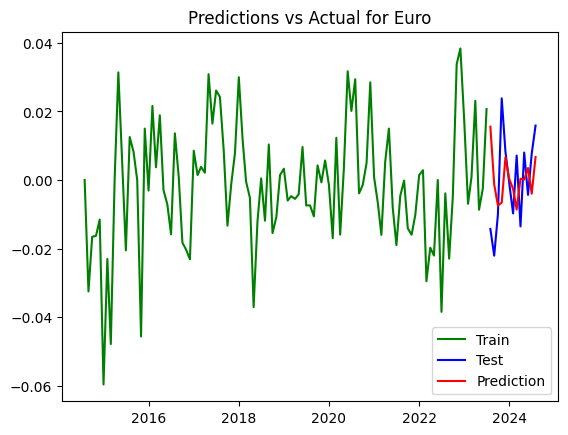

In [466]:
# Plot of predictions vs actual values
plt.plot(euro_train,color="green",label="Train")
plt.plot(euro_test,label="Test",color="b")
plt.plot(euro_pred,label="Prediction",color="r")
plt.legend()
plt.title("Predictions vs Actual for Euro");

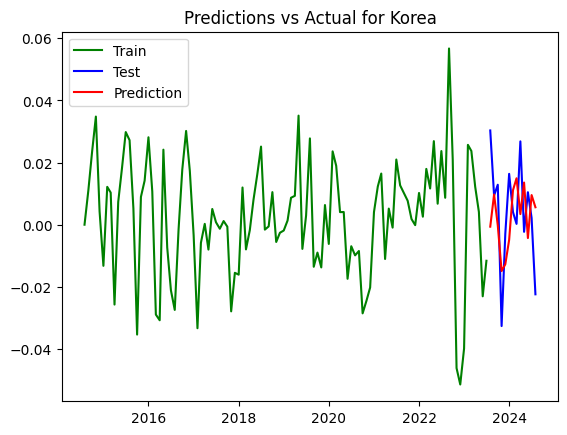

In [480]:
plt.plot(korea_train,color="green",label="Train")
plt.plot(korea_test,label="Test",color="b")
plt.plot(korea_pred,label="Prediction",color="r")
plt.legend()
plt.title("Predictions vs Actual for Korea");

In [471]:
# Model evaluation
euro_metrics = {}
korea_metrics = {}
euro_metrics["MSE"] = mean_squared_error(euro_test,euro_pred)
euro_metrics["MAE"] = mean_absolute_error(euro_test, euro_pred)
euro_metrics["R2"] = r2_score(euro_test,euro_pred)
korea_metrics["MSE"] = mean_squared_error(korea_test,korea_pred)
korea_metrics["MAE"] = mean_absolute_error(korea_test,korea_pred)
korea_metrics["R2"] = r2_score(korea_test,korea_pred)

In [469]:
euro_metrics # negative R2 means that the baseline model of predicting mean performs better than our model

{'MSE': 0.00023825959656434073,
 'MAE': 0.012317431832418985,
 'R2': -0.43826225488111703}

In [472]:
korea_metrics # small error but that's partly due to the already small scale of the input data

{'MSE': 0.00031610444004950215,
 'MAE': 0.01570568301994845,
 'R2': -0.12417949069555334}

In [473]:
# Model diagnostics: check for any remaining correlation among residual terms
euro_resid = euro_test - euro_pred
korea_resid = korea_test - korea_pred 

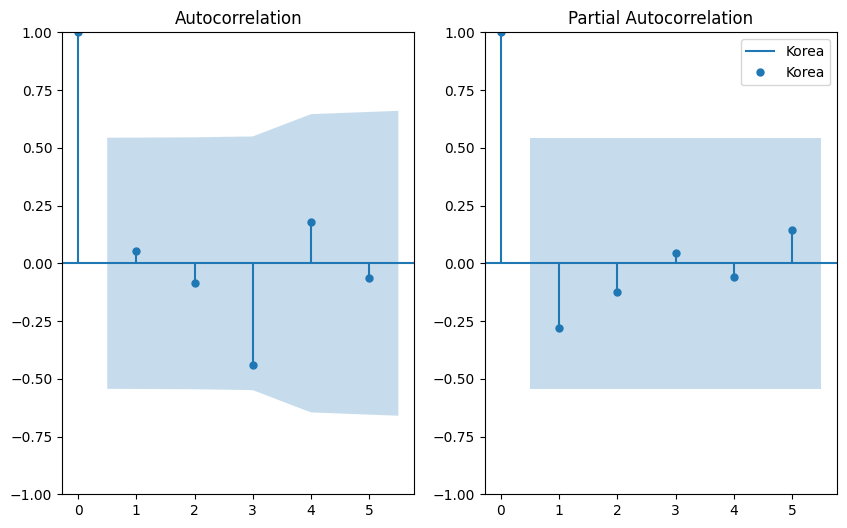

In [476]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
plot_acf(euro_resid,ax=axs[0], lags=5,label="Euro")
plot_pacf(korea_resid,ax=axs[1],lags=5,label="Korea")
plt.legend();

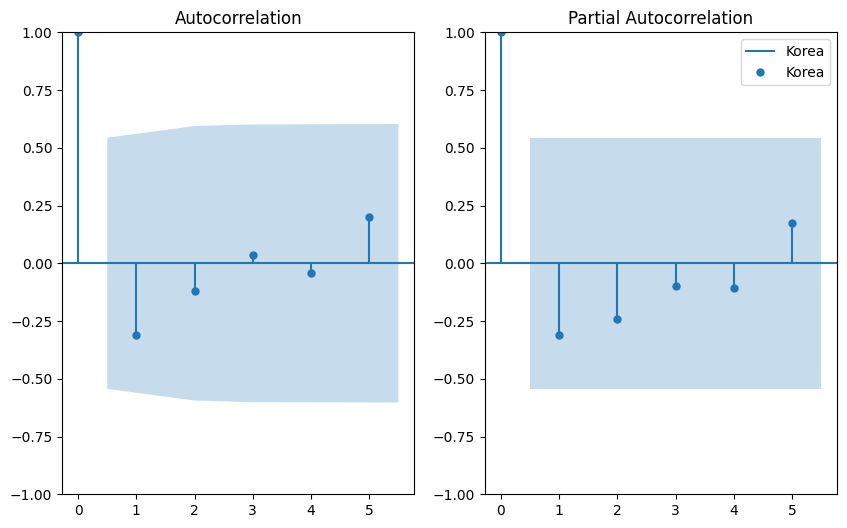

In [481]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
plot_acf(np.square(korea_resid),ax=axs[0], lags=5,label="Korea")
plot_pacf(np.square(korea_resid),ax=axs[1],lags=5,label="Korea")
plt.legend();

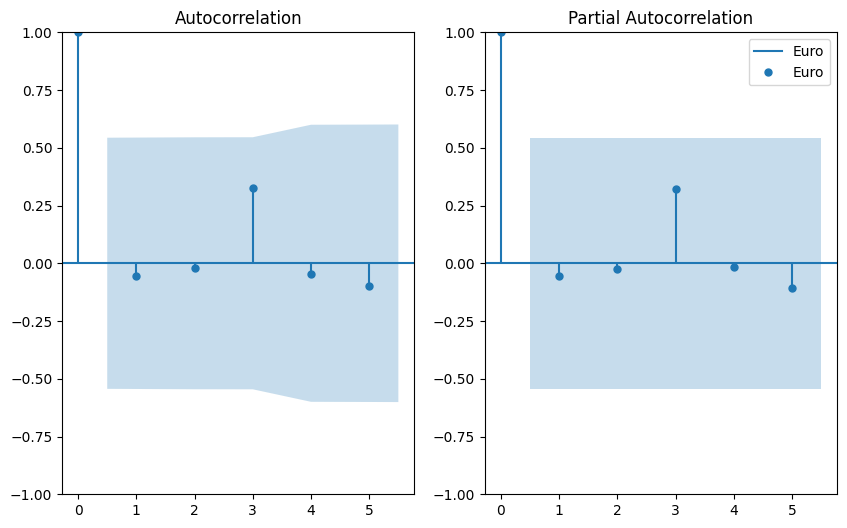

In [482]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
plot_acf(np.square(euro_resid),ax=axs[0], lags=5,label="Euro")
plot_pacf(np.square(euro_resid),ax=axs[1],lags=5,label="Euro")
plt.legend();

In [485]:
# Model fitting on the entire dataset, no split
euro_full_model = SARIMAX(euro_df["logdiff"], order=(1,0,0),seasonal_order=(0,1,1,12))
korea_full_model = SARIMAX(korea_df["logdiff"],order=(0,0,1), seasonal_order=(0,1,2,12))

In [486]:
euro_full_model = euro_full_model.fit()
korea_full_model = korea_full_model.fit()

In [487]:
# korea_df.fillna(0,inplace=True)
euro_fullresid = euro_df["logdiff"] - euro_full_model.predict(0,korea_df.shape[0]-1)
korea_fullresid = korea_df["logdiff"] - korea_full_model.predict(0,len(korea_df)-1)

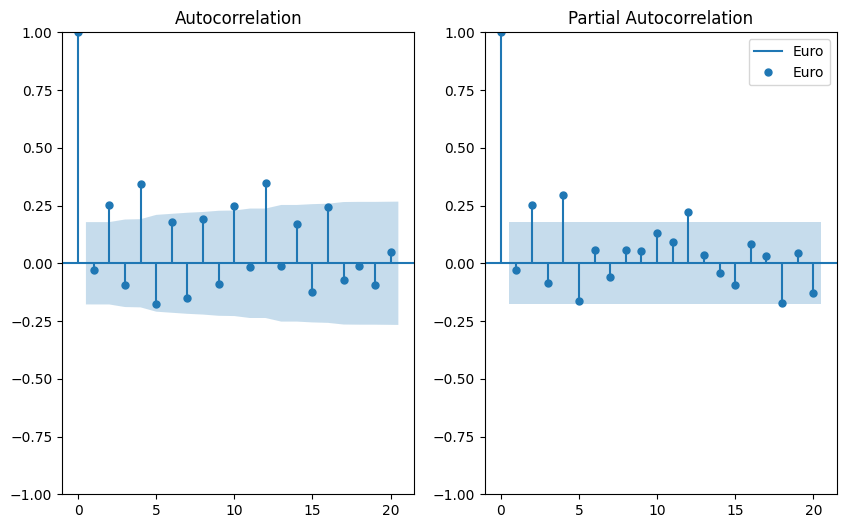

In [489]:
# plot of squared residuals shows dependency 
fig, axs = plt.subplots(1,2, figsize=(10,6))
plot_acf(np.square(euro_fullresid),ax=axs[0], lags=20,label="Euro")
plot_pacf(np.square(euro_fullresid),ax=axs[1],lags=20,label="Euro")
plt.legend();

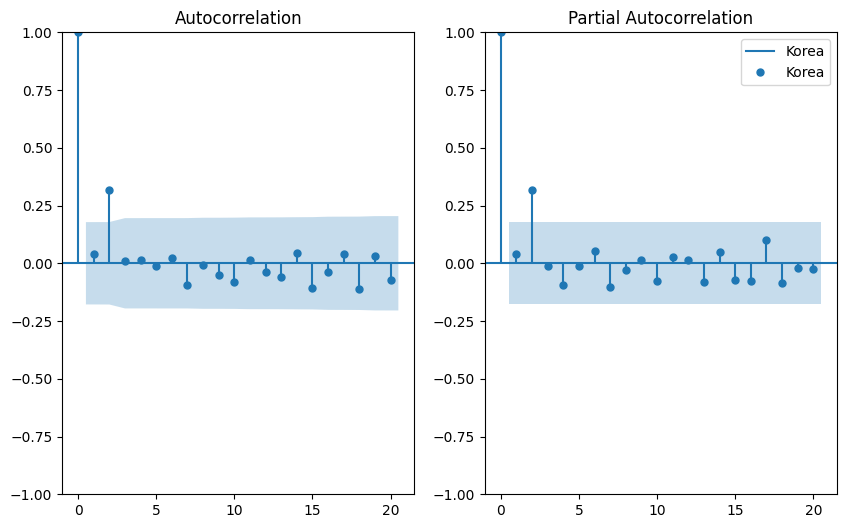

In [410]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
acf = plot_acf(np.square(korea_fullresid),ax=axs[0], lags=20,label="Korea")
pacf = plot_pacf(np.square(korea_fullresid),ax=axs[1],lags=20,label="Korea")
plt.legend();

In [492]:
acorr_ljungbox(np.square(euro_fullresid)) # serial correlation detected for EUR

,lb_stat,lb_pvalue
1,0.115787,7.336495e-01
2,8.174178,1.678804e-02
3,9.249348,2.615295e-02
4,24.168867,7.388429e-05
5,28.222679,3.292605e-05
6,32.269380,1.448746e-05
7,35.231070,1.011969e-05
8,40.170691,2.977480e-06
9,41.218441,4.564185e-06
10,49.502207,3.294782e-07


In [490]:
acorr_ljungbox(np.square(korea_fullresid)) # no correlation for KRW

,lb_stat,lb_pvalue
1,0.590520,0.442218
2,1.931053,0.380783
3,3.856730,0.277356
4,4.148279,0.386310
5,4.270161,0.511211
6,4.322650,0.633101
7,4.426265,0.729577
8,4.426585,0.816732
9,7.424028,0.593061
10,7.848693,0.643614


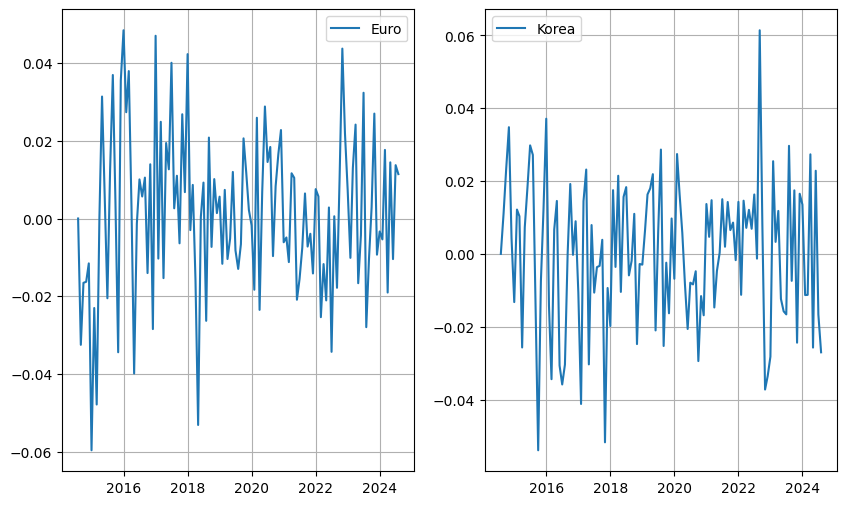

In [491]:
# plots of residuals
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].plot(euro_fullresid,label="Euro")
axs[1].plot(korea_fullresid,label="Korea")
for ax in axs:
    ax.grid(True)
    ax.legend()

In [510]:
# modeling conditional volatility with GARCH
model_euro = arch_model(euro_fullresid,vol="GARCH",p=1,o=1,q=1, mean="Constant")
results_euro = model_euro.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4310891.187139046
Iteration:      2,   Func. Count:     19,   Neg. LLF: 824656.2665885238
Iteration:      3,   Func. Count:     30,   Neg. LLF: -302.5624218359864
Optimization terminated successfully    (Exit mode 0)
            Current function value: -302.5624224296698
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


In [511]:
results_euro.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                302.562
Distribution:                  Normal   AIC:                          -595.125
Method:            Maximum Likelihood   BIC:                          -581.146
                                        No. Observations:                  121
Date:                Sun, Sep 08 2024   Df Residuals:                      120
Time:                        01:53:03   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.0226e-04  2.009e-03      0.349      0.727 [-3.236e-03,4.641e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.4382e-06  9.192e-11  9.180e+04      0.000 [8.438e-06,8.438e-06]
alpha[1]       0.0500      0.126      0.397      0.691     [ -0.197,  0.297]
gamma[1]       0.0500  9.283e-02      0.539      0.590     [ -0.132,  0.232]
beta[1]        0.9050      0.109      8.311  9.493e-17     [  0.692,  1.118]
============================================================================

Covariance estimator: robust
"""

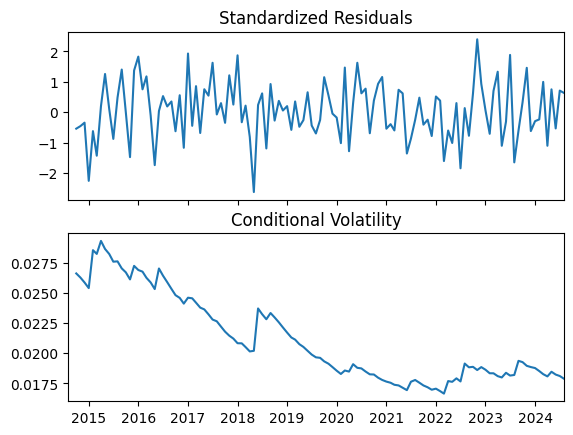

In [503]:
# plot of standardized residuals look approximately normal with mean 0
results_euro.plot();

In [507]:
results_euro.std_resid.describe() # the first 2 are nan because we specified a AR(2) model for the mean

count    119.000000
mean       0.045717
std        0.945238
min       -2.625020
25%       -0.599945
50%        0.061391
75%        0.645512
max        2.398396
Name: std_resid, dtype: float64

In [506]:
acorr_ljungbox(results_euro.std_resid[2:]) # no serial correlation remains

,lb_stat,lb_pvalue
1,0.129165,0.719299
2,0.242175,0.885957
3,0.889542,0.827951
4,2.797856,0.592203
5,2.813009,0.728787
6,2.825875,0.830363
7,3.855569,0.796255
8,3.863622,0.869213
9,4.262122,0.893329
10,4.338208,0.930803


<b> To conclude, our final models for Euro and Korea exchange rate with the US look like this:
1. Korea: 
- Mean model: ARMA(2,0,2)
- EGARCH(0,1)
2. Euro:
- Mean model: ARMA(1,0,2)

ToDos: Using other form of GARCH that accounts for volatility in making point prediction and deep learning